In [2]:
#%load_ext jupyter_black

In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from matplotlib import pyplot as plt
from pylab import rcParams
import sklearn
from sklearn.linear_model import LinearRegression
import talib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MaxAbsScaler
import time
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.metrics import *
import os
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import optuna

In [2]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

<h1 style="font-size:40px;"> <center> FUNCTIONS </center> </h1>

In [3]:
SEED = 42


def set_random_seed():
    tf.keras.utils.set_random_seed(SEED)


def HMA(df: pd.DataFrame, timeperiod: int = 14) -> float:
    """
    Hull Moving Average.
    Formula:
    HMA = WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
    """
    hma = talib.WMA(
        2 * talib.WMA(df, int(timeperiod / 2)) - talib.WMA(df, timeperiod),
        int(np.sqrt(timeperiod)),
    )
    return hma


def money_flow_volume_series(df: pd.DataFrame) -> pd.Series:
    """
    Calculates money flow series
    """
    mfv = (
        df["Volume"]
        * (2 * df["Close"] - df["High"] - df["Low"])
        / (df["High"] - df["Low"])
    )
    return mfv


def money_flow_volume(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates money flow volume, or q_t in our formula
    """
    return money_flow_volume_series(df).rolling(timeperiod).sum()


def CMF(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates the Chaikin money flow
    """
    return money_flow_volume(df, timeperiod) / df["Volume"].rolling(timeperiod).sum()


def pltcolor(lst: list) -> list:
    cols = []
    for i in range(lst.shape[0]):
        if lst.iloc[i] == 1:
            cols.append("green")
        elif lst.iloc[i] == 2:
            cols.append("red")
    return cols


def trendNormalizePrices(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["rowNumber"] = list(range(len(df)))
    df["TN_Open"] = list(range(len(df)))
    df["TN_High"] = list(range(len(df)))
    df["TN_Low"] = list(range(len(df)))
    df["TN_Close"] = list(range(len(df)))
    for i in range(29, len(df)):
        model = LinearRegression()
        model.fit(
            np.array(df["rowNumber"].iloc[i - 29 : i + 1]).reshape(-1, 1),
            np.array(df["Close"].iloc[i - 29 : i + 1]),
        )
        prediction = model.predict(np.array([df["rowNumber"].iloc[i]]).reshape(-1, 1))
        df.iloc[i, df.columns.get_loc("TN_Open")] = df["Open"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_High")] = df["High"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Low")] = df["Low"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Close")] = df["Close"].iloc[i] - prediction
    df["Open"] = df["TN_Open"]
    df["High"] = df["TN_High"]
    df["Low"] = df["TN_Low"]
    df["Close"] = df["TN_Close"]
    df = df.drop(index=df.index[:30], axis=0)
    df = df.drop(
        columns=["TN_Open", "TN_High", "TN_Low", "TN_Close", "rowNumber"], axis=1
    )
    return df


def create_labels(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["Label"] = [0] * df.shape[0]
    for i in range(df.shape[0] - 10):
        s = set(df["Close"].iloc[i : i + 11])
        minPrice = sorted(s)[0]
        maxPrice = sorted(s)[-1]
        for j in range(i, i + 11):
            if df["Close"].iloc[j] == minPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 1
            elif df["Close"].iloc[j] == maxPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 2
    return df.iloc[6:-6]


def reverse_one_hot(predictions: np.array) -> np.array:
    return np.argmax(predictions, axis=1)


def one_hot(predictions: np.array) -> np.array:
    predictions_one_hot = []
    for i in predictions:
        prediction = [0, 0, 0]
        prediction[int(i)] = 1
        predictions_one_hot.append(prediction)
    return np.array(predictions_one_hot)


def number_null_and_nan(df: pd.DataFrame) -> int:
    na = pd.isna(df).sum().sum()
    null = df.isnull().sum().sum()
    return na + null

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [4]:
prices = yf.download(
    "SPY",
    start="2009-09-20",
    end="2023-01-01",
    interval="1d",
    progress=False,
    auto_adjust=True,
)
prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-09-21 00:00:00-04:00,82.204697,83.066414,82.026146,82.639435,151892000
2009-09-22 00:00:00-04:00,83.128515,83.353649,82.755878,83.120750,143126700
2009-09-23 00:00:00-04:00,83.314854,83.866042,82.282345,82.429848,225947400
2009-09-24 00:00:00-04:00,82.608412,82.786963,81.164453,81.521561,228636800
2009-09-25 00:00:00-04:00,81.342949,81.793217,80.807285,81.086761,204059000
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,59857300
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,51638200
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,70911500


In [ ]:
plt.figure(figsize=(20, 10))
plt.title("SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Trend Normalize and Visualize </center> </h1>

In [5]:
tn_prices = trendNormalizePrices(prices)
tn_prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-11-02 00:00:00-05:00,-2.497205,-1.503508,-3.312339,-2.349702,254222900
2009-11-03 00:00:00-05:00,-2.646069,-1.823164,-2.801331,-1.939613,228362600
2009-11-04 00:00:00-05:00,-1.110675,-0.474091,-1.778312,-1.568708,247996700
2009-11-05 00:00:00-05:00,-0.968834,-0.021726,-1.139625,-0.045015,180015300
2009-11-06 00:00:00-05:00,-0.466997,0.418009,-0.630024,0.208399,170954100
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,-7.306054,-3.896050,-8.926049,-4.046044,59857300
2022-12-27 00:00:00-05:00,-2.835277,-2.475292,-5.975292,-4.225292,51638200
2022-12-28 00:00:00-05:00,-2.236787,-0.176759,-7.146761,-6.906770,70911500


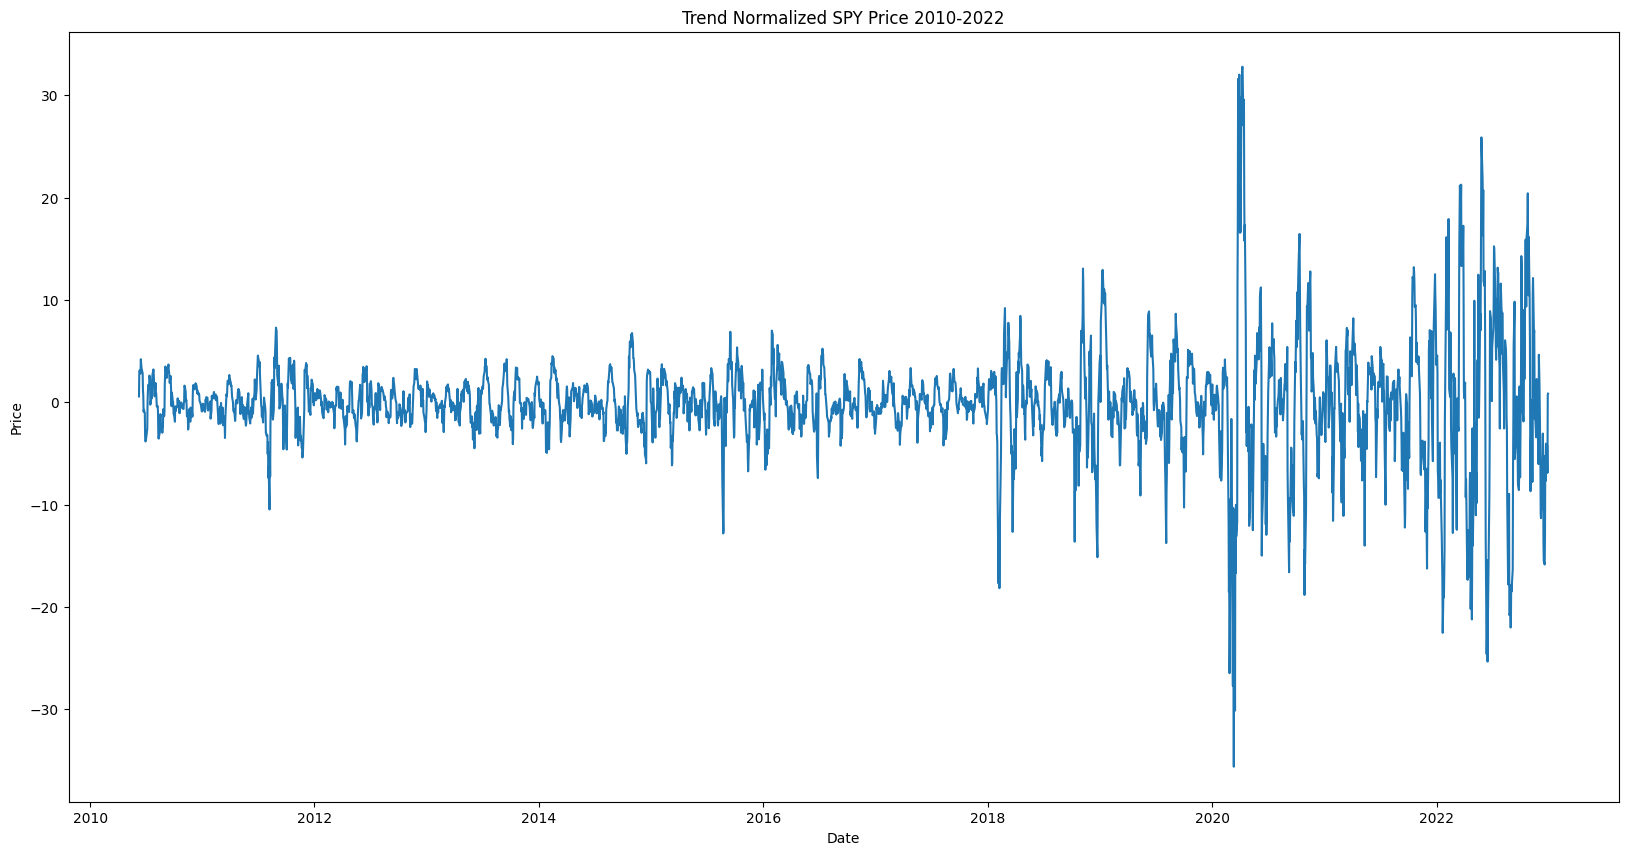

In [6]:
plt.figure(figsize=(20, 10))
plt.title("Trend Normalized SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(tn_prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [7]:
prices_and_indicators = tn_prices.copy()

In [8]:
for i in range(7, 30):
    prices_and_indicators[f"RSI-{i}"] = talib.RSI(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WILLR-{i}"] = talib.WILLR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"STOCH-{i}"] = talib.STOCH(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i + 7,
        slowk_period=i - 4,
    )[0]
    prices_and_indicators[f"STOCHF-{i}"] = talib.STOCHF(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i - 2,
        fastd_period=i - 4,
    )[0]
    prices_and_indicators[f"SMA-{i}"] = talib.SMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"EMA-{i}"] = talib.EMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WMA-{i}"] = talib.WMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"HMA-{i}"] = HMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"TEMA-{i}"] = talib.TEMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"PPO-{i}"] = talib.PPO(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )
    prices_and_indicators[f"ROC-{i}"] = talib.ROC(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"CMO-{i}"] = talib.CMO(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"MACD-{i}"] = talib.MACD(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )[0]
    prices_and_indicators[f"MAMA-{i}"] = talib.MAMA(
        prices_and_indicators["Close"], fastlimit=1 / i, slowlimit=1 / (i + 14)
    )[0]
    prices_and_indicators[f"STOCHRSI-{i}"] = talib.STOCHRSI(
        prices_and_indicators["Close"], timeperiod=i
    )[0]
    prices_and_indicators[f"DX-{i}"] = talib.DX(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADXR-{i}"] = talib.ADXR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"CCI-{i}"] = talib.CCI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"PLUS_DI-{i}"] = talib.PLUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"MINUS_DI-{i}"] = talib.MINUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ATR-{i}"] = talib.ATR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"SAR-{i}"] = talib.SAR(
        prices_and_indicators["High"], prices_and_indicators["Low"], maximum=1 / i
    )
    prices_and_indicators[f"PLUS_DM-{i}"] = talib.PLUS_DM(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"AROONOSC-{i}"] = talib.AROONOSC(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MIDPRICE-{i}"] = talib.MIDPRICE(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MFI-{i}"] = talib.MFI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        fastperiod=i - 4,
        slowperiod=i + 3,
    )
    prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(
        prices_and_indicators["Close"], timeperiod=i
    )[1]
    prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod=i)
prices_and_indicators["BOP"] = talib.BOP(
    prices_and_indicators["Open"],
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["TRANGE"] = talib.TRANGE(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["SAREXT"] = talib.SAREXT(
    prices_and_indicators["High"], prices_and_indicators["Low"]
)
prices_and_indicators["AD"] = talib.AD(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
    prices_and_indicators["Volume"],
)
prices_and_indicators["OBV"] = talib.OBV(
    prices_and_indicators["Close"], prices_and_indicators["Volume"]
)
prices_and_indicators.dropna(inplace=True)

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [9]:
prices_and_indicators

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,ADXR-21,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [10]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS_DI-29,M

In [11]:
prices_and_indicators_with_label["Label"].value_counts()

0    2796
1     216
2     205
Name: Label, dtype: int64

<Figure size 5000x3000 with 0 Axes>

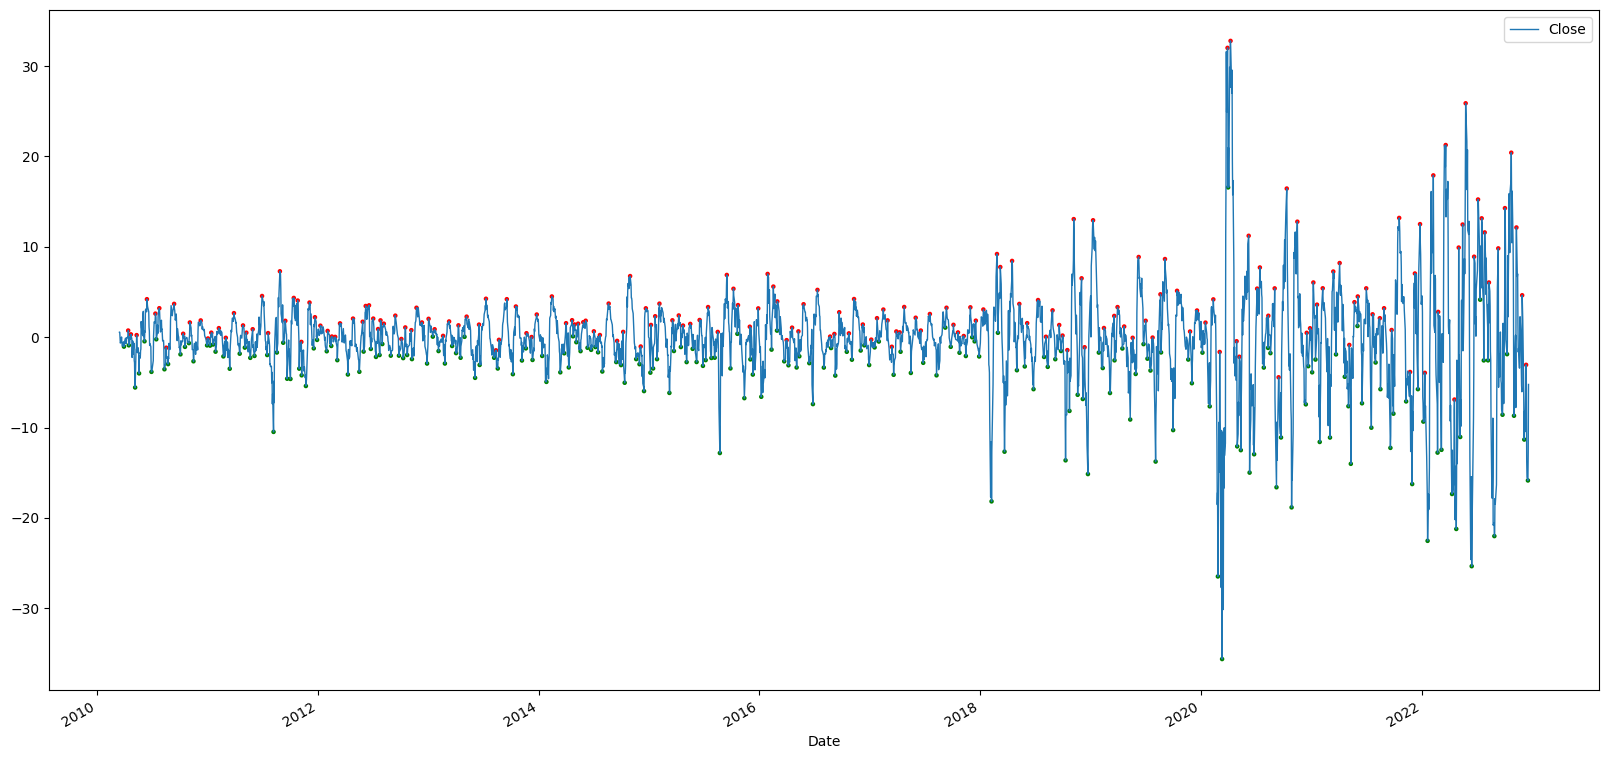

In [12]:
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_and_indicators_with_label[["Close"]].plot(
    kind="line", stacked=False, linewidth=1
)
buy_and_sell_preds = prices_and_indicators_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<Figure size 5000x3000 with 0 Axes>

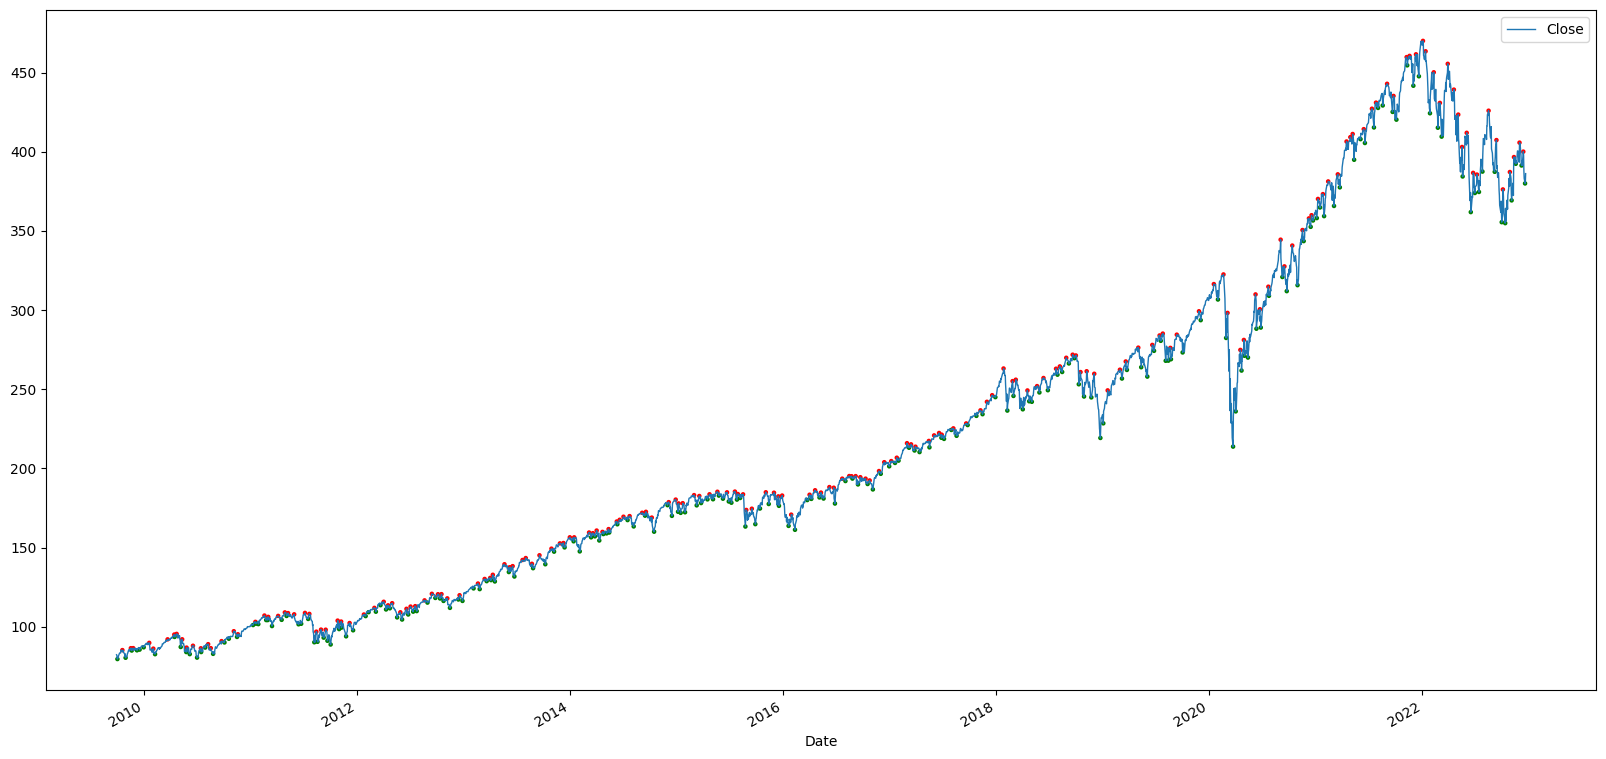

In [13]:
prices_with_label = create_labels(prices)
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_with_label[["Close"]].plot(kind="line", stacked=False, linewidth=1)
buy_and_sell_preds = prices_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [14]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3217 entries, 2010-03-16 00:00:00-04:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(2)
memory usage: 16.7 MB


In [15]:
datas = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i-5}")
        & (prices_and_indicators_with_label.index <= f"{2010+i}")
    ]
    test = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i}")
        & (prices_and_indicators_with_label.index <= f"{2010+i+1}")
    ]
    datas.append([train, test])

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [16]:
for i in range(len(datas)):
    selected_feature_count = 30
    select = SelectKBest(score_func=f_classif, k=selected_feature_count)
    fitted = select.fit(datas[i][0].iloc[:, :-1], datas[i][0].iloc[:, -1])
    train_features = fitted.transform(datas[i][0].iloc[:, :-1])
    test_features = fitted.transform(datas[i][1].iloc[:, :-1])

    selected_features_boolean = select.get_support()
    features = list(datas[i][1].columns[:-1])
    selected_features = []
    for j in range(len(features)):
        if selected_features_boolean[j]:
            selected_features.append(features[j])
    train_label = datas[i][0].Label
    test_label = datas[i][1].Label

    datas[i][0] = pd.DataFrame(
        data=train_features.astype("float32"),
        columns=selected_features,
        index=datas[i][0].index,
    )
    datas[i][0]["Label"] = train_label
    datas[i][1] = pd.DataFrame(
        data=test_features.astype("float32"),
        columns=selected_features,
        index=datas[i][1].index,
    )
    datas[i][1]["Label"] = test_label

In [17]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,37.759518,-52.957172,55.302734,-24.480967,39.590725,-58.703861,48.986912,-20.818550,41.267471,-58.703861,47.042828,-17.465057,42.725330,41.296139,-14.549335,41.296139,38.374680,37.566837,36.876404,36.292786,35.784966,35.331791,34.933289,34.588467,34.277313,34.001865,33.768452,33.553600,33.349930,33.158443,0
2010-03-17 00:00:00-04:00,37.574379,-51.516842,68.048477,-24.851242,39.431995,-53.440937,54.734032,-21.136009,41.128902,-59.128529,48.483158,-17.742193,42.602783,46.559063,-14.794434,40.871471,43.805725,42.839447,42.015247,41.319546,40.715191,40.176693,39.703781,39.294968,38.926533,38.600712,38.324795,38.071083,37.830791,37.605080,0
2010-03-18 00:00:00-04:00,28.815712,-75.485008,30.961561,-42.368576,31.711205,-78.284737,30.478437,-36.577591,34.253426,-79.146523,24.514988,-31.493147,36.433002,21.715267,-27.133999,20.853477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-19 00:00:00-04:00,21.402525,-82.355423,19.091791,-57.194950,24.677891,-84.927971,17.839901,-50.644218,27.634264,-86.249054,17.644577,-44.731472,30.236248,15.072026,-39.527504,13.750942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-22 00:00:00-04:00,29.434179,-56.419823,46.038395,-41.131641,31.283161,-56.809151,46.038395,-37.433678,33.145752,-62.089005,43.580177,-33.708500,34.901608,43.190849,-30.196783,37.910995,28.040810,27.258194,26.583557,26.004086,25.496586,25.043947,24.643211,24.290981,23.973066,23.688923,23.440701,23.212904,22.999773,22.801161,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,71.148285,-34.316051,40.715530,42.296570,69.421318,-33.947926,63.216091,38.842632,67.860649,-33.947926,65.683945,35.721298,66.457672,66.052071,32.915340,66.052071,38.976665,41.139561,42.995068,44.600311,45.999649,47.227997,48.313122,49.277367,50.138844,50.912380,51.610199,52.242451,52.817619,53.342846,0
2014-12-26 00:00:00-05:00,72.135994,-34.939289,70.911537,44.271984,70.322456,-32.595192,43.688492,40.644920,68.696564,-32.245525,65.060707,37.393127,67.241142,67.404808,34.482281,67.754471,41.028305,42.038383,42.964359,43.813450,44.592587,45.308270,45.966537,46.572910,47.132412,47.649586,48.592075,49.692589,50.692661,51.604885,0
2014-12-29 00:00:00-05:00,70.688011,-57.836273,50.269207,41.376026,69.128372,-35.885353,63.717609,38.256744,67.680885,-33.477779,42.163727,35.361767,66.357872,64.114647,32.715748,66.522217,6.385787,7.616255,8.736430,9.757986,10.691341,11.545792,12.329607,13.050140,13.713917,14.326723,14.893689,15.419363,15.907777,16.362511,0


In [18]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,42.521027,-77.039177,23.588654,-14.957945,44.853821,-77.039177,23.588654,-10.292361,46.391556,-77.039177,22.960825,-7.216887,47.422092,22.960825,-5.155817,22.960825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-05 00:00:00-05:00,27.883297,-95.156967,5.039087,-44.233406,31.124931,-95.247108,4.843033,-37.750137,33.593716,-95.247108,4.843033,-32.812572,35.501545,4.752888,-28.996906,4.752888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-06 00:00:00-05:00,24.230883,-89.828804,11.567318,-51.538235,27.512852,-89.828804,10.501927,-44.974297,30.089005,-89.982582,10.171200,-39.821991,32.133171,10.171200,-35.733654,10.017414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2015-01-07 00:00:00-05:00,43.844372,-59.277504,45.624676,-12.311257,44.374313,-60.559940,44.853680,-11.251372,44.875633,-60.559940,40.722496,-10.248737,45.310162,39.440060,-9.379678,39.440060,72.644379,71.865082,71.200844,70.626610,70.124008,69.679291,69.282051,68.924271,68.599709,68.303421,68.031433,67.780563,67.548157,67.332054,0
2015-01-08 00:00:00-05:00,58.889385,-14.810065,96.452888,17.778772,57.927792,-22.656361,86.654282,15.855583,57.212883,-25.092073,85.189934,14.425766,56.644363,77.343643,13.288727,74.907928,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2
2015-01-09 00:00:00-05:00,50.927357,-33.867924,71.318138,1.854710,50.845890,-34.985470,71.318138,1.691782,50.813564,-40.973537,66.132080,1.627132,50.794025,65.014534,1.588048,59.026463,75.166588,75.074837,74.993263,74.919899,74.853233,74.792107,74.735626,74.683113,74.634003,74.587868,74.544357,74.503189,74.464127,74.426964,0
2015-01-12 00:00:00-05:00,44.741367,-48.080795,51.919205,-10.517263,45.298321,-51.856220,51.919205,-9.403362,45.765797,-52.669785,51.919205,-8.468405,46.151699,48.143780,-7.696604,47.330215,54.978146,54.753582,54.551399,54.367657,54.199314,54.043987,53.899818,53.765324,53.639313,53.520813,53.409023,53.303276,53.203007,53.107727,0
2015-01-13 00:00:00-05:00,43.234245,-52.852726,28.193359,-13.531511,43.950237,-52.852726,47.147274,-12.099528,44.541317,-56.281151,47.147274,-10.917366,45.026913,47.147274,-9.946172,43.718849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-14 00:00:00-05:00,39.824905,-63.247700,32.366680,-20.350191,40.918606,-63.247700,32.366680,-18.162792,41.800537,-63.247700,36.752300,-16.398926,42.518791,36.752300,-14.962418,36.752300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [19]:
for i in range(len(datas)):
    abs_scaler = MaxAbsScaler()
    abs_scaler.fit(datas[i][0])
    scaled_train = abs_scaler.transform(datas[i][0])
    scaled_test = abs_scaler.transform(datas[i][1])
    datas[i][0] = pd.DataFrame(
        data=scaled_train, columns=datas[i][0].columns, index=datas[i][0].index
    )
    datas[i][0]["Label"] = datas[i][0]["Label"] * 2
    datas[i][1] = pd.DataFrame(
        data=scaled_test, columns=datas[i][1].columns, index=datas[i][1].index
    )
    datas[i][1]["Label"] = datas[i][1]["Label"] * 2

In [20]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,0.445699,-0.529572,0.553027,-0.350302,0.481726,-0.587039,0.489869,-0.323418,0.516425,-0.587039,0.470428,-0.291962,0.548755,0.412961,-0.259980,0.412961,0.383747,0.375668,0.368764,0.362928,0.357850,0.353318,0.349333,0.345885,0.342773,0.340019,0.337685,0.335536,0.333499,0.331584,0.0
2010-03-17 00:00:00-04:00,0.443514,-0.515168,0.680485,-0.355600,0.479794,-0.534409,0.547340,-0.328350,0.514691,-0.591285,0.484832,-0.296595,0.547181,0.465591,-0.264360,0.408715,0.438057,0.428394,0.420152,0.413195,0.407152,0.401767,0.397038,0.392950,0.389265,0.386007,0.383248,0.380711,0.378308,0.376051,0.0
2010-03-18 00:00:00-04:00,0.340130,-0.754850,0.309616,-0.606259,0.385850,-0.782847,0.304784,-0.568236,0.428651,-0.791465,0.245150,-0.526468,0.467938,0.217153,-0.484854,0.208535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-19 00:00:00-04:00,0.252627,-0.823554,0.190918,-0.818412,0.300272,-0.849280,0.178399,-0.786762,0.345818,-0.862491,0.176446,-0.747772,0.388348,0.150720,-0.706312,0.137509,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-22 00:00:00-04:00,0.347430,-0.564198,0.460384,-0.588559,0.380642,-0.568092,0.460384,-0.581535,0.414789,-0.620890,0.435802,-0.563502,0.448269,0.431908,-0.539582,0.379110,0.280408,0.272582,0.265836,0.260041,0.254966,0.250439,0.246432,0.242910,0.239731,0.236889,0.234407,0.232129,0.229998,0.228012,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,0.839808,-0.343161,0.407155,0.605229,0.844693,-0.339479,0.632161,0.603423,0.849215,-0.339479,0.656839,0.597150,0.853568,0.660521,0.588160,0.660521,0.389767,0.411396,0.429951,0.446003,0.459996,0.472280,0.483131,0.492774,0.501388,0.509124,0.516102,0.522425,0.528176,0.533428,0.0
2014-12-26 00:00:00-05:00,0.851466,-0.349393,0.709115,0.633495,0.855658,-0.325952,0.436885,0.631422,0.859676,-0.322455,0.650607,0.625097,0.863631,0.674048,0.616159,0.677545,0.410283,0.420384,0.429644,0.438134,0.445926,0.453083,0.459665,0.465729,0.471324,0.476496,0.485921,0.496926,0.506927,0.516049,0.0
2014-12-29 00:00:00-05:00,0.834375,-0.578363,0.502692,0.592056,0.841129,-0.358854,0.637176,0.594322,0.846966,-0.334778,0.421637,0.591139,0.852286,0.641146,0.584593,0.665222,0.063858,0.076163,0.087364,0.097580,0.106913,0.115458,0.123296,0.130501,0.137139,0.143267,0.148937,0.154194,0.159078,0.163625,0.0


In [21]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,0.501902,-0.770392,0.235887,-0.214036,0.545765,-0.770392,0.235887,-0.159893,0.580549,-0.770392,0.229608,-0.120644,0.609079,0.229608,-0.092129,0.229608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-05 00:00:00-05:00,0.329124,-0.951570,0.050391,-0.632943,0.378717,-0.952471,0.048430,-0.586451,0.420395,-0.952471,0.048430,-0.548525,0.455974,0.047529,-0.518142,0.047529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-06 00:00:00-05:00,0.286012,-0.898288,0.115673,-0.737469,0.334766,-0.898288,0.105019,-0.698679,0.376537,-0.899826,0.101712,-0.665701,0.412712,0.101712,-0.638520,0.100174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2015-01-07 00:00:00-05:00,0.517522,-0.592775,0.456247,-0.176164,0.539931,-0.605599,0.448537,-0.174791,0.561578,-0.605599,0.407225,-0.171327,0.581954,0.394401,-0.167604,0.394401,0.726444,0.718651,0.712008,0.706266,0.701240,0.696793,0.692821,0.689243,0.685997,0.683034,0.680314,0.677806,0.675482,0.673321,0.0
2015-01-08 00:00:00-05:00,0.695108,-0.148101,0.964529,0.254399,0.704844,-0.226564,0.866543,0.246318,0.715968,-0.250921,0.851899,0.241154,0.727528,0.773436,0.237454,0.749079,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
2015-01-09 00:00:00-05:00,0.601127,-0.338679,0.713181,0.026539,0.618674,-0.349855,0.713181,0.026282,0.635886,-0.409735,0.661321,0.027201,0.652388,0.650145,0.028377,0.590265,0.751666,0.750748,0.749933,0.749199,0.748532,0.747921,0.747356,0.746831,0.746340,0.745879,0.745444,0.745032,0.744641,0.744270,0.0
2015-01-12 00:00:00-05:00,0.528110,-0.480808,0.519192,-0.150493,0.551174,-0.518562,0.519192,-0.146082,0.572718,-0.526698,0.519192,-0.141566,0.592762,0.481438,-0.137530,0.473302,0.549781,0.547536,0.545514,0.543677,0.541993,0.540440,0.538998,0.537653,0.536393,0.535208,0.534090,0.533033,0.532030,0.531077,0.0
2015-01-13 00:00:00-05:00,0.510321,-0.528527,0.281934,-0.193625,0.534771,-0.528527,0.471473,-0.187967,0.557395,-0.562812,0.471473,-0.182505,0.578316,0.471473,-0.177727,0.437188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-14 00:00:00-05:00,0.470078,-0.632477,0.323667,-0.291194,0.497883,-0.632477,0.323667,-0.282160,0.523096,-0.632477,0.367523,-0.274139,0.546102,0.367523,-0.267361,0.367523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [22]:
total_na_count = 0
for data in datas:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


<h1 style="font-size:40px;"> <center> MODEL INITIALIZATIONS </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
def create_model_MLP(trial=None, activation_func="swish", dropout_rate = 0.2, optimizer_algo = "adam"):
    MLP = Sequential()
    MLP.add(Dense(64, input_shape=(30,), activation=activation_func, kernel_initializer=tf.keras.initializers.HeUniform()))
    MLP.add(BatchNormalization())
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(3, activation='softmax'))
    MLP.compile(loss="categorical_crossentropy", optimizer=optimizer_algo, metrics=["accuracy","Precision","Recall","AUC",tfa.metrics.F1Score(num_classes=3, average="macro")])
    return MLP

In [ ]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='val_f1_score', verbose=0, 
                          save_best_only=True, save_weights_only=False, mode='max')
    
    val_split_point = int(0.5*len(datas[i][0]))
    X_train = datas[i][0][:val_split_point].iloc[:, :-1]
    y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
    X_val = datas[i][0][val_split_point:].iloc[:, :-1]
    y_val = tf.keras.utils.to_categorical(datas[i][0][val_split_point:].iloc[:, -1], num_classes = 3)
    X_test = datas[i][1].iloc[:, :-1]
    y_test = datas[i][1].iloc[:, -1]
    
    model = create_model_MLP()
    model.fit(X_train, y_train, batch_size=64, 
                        epochs=1, verbose=0, callbacks=[es, mcp], 
                        validation_data=(X_val, y_val), 
                        class_weight={0:1, 1:10, 2:10})
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    
print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes\n")

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [126]:
cnn_datas = []

In [127]:
df = datas[0][0].drop(columns=["Label"])
df_matrix_train = pd.DataFrame(
    index=df.iloc[29:].index,
)
df_matrix_train["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

for i in range(df_matrix_train.shape[0]):
    matrix = df.iloc[i : i + 30].values.reshape((30, 30, -1))
    df_matrix_train.iloc[i, 0] = matrix
df_matrix_train["Label"] = datas[0][0].iloc[29:, -1]

df = datas[0][1].drop(columns=["Label"])
df_matrix_test = pd.DataFrame(
    index=df.iloc[29:].index,
)
df_matrix_test["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

for i in range(df_matrix.shape[0]):
    matrix = df.iloc[i : i + 30].values.reshape((30, 30, -1))
    df_matrix_test.iloc[i, 0] = matrix
df_matrix_test["Label"] = datas[0][1].iloc[29:, -1]

In [133]:
df_matrix_test["Label"].value_counts()

0.0    195
1.0     16
2.0     12
Name: Label, dtype: int64

In [134]:
cnn_datas.append((df_matrix_train, df_matrix_test))

In [135]:
def create_model_CNN_2D(trial=None,activation_func="relu", dropout_rate=0.2, optimizer_algo="adam", kernel=3, pooling=3):
    CNN_2D = Sequential()
    CNN_2D.add(Conv2D(filters=64, kernel_size=(kernel, kernel), input_shape=(30,30,1), padding = "same",  activation=activation_func, kernel_initializer=tf.keras.initializers.HeUniform()))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling),padding = "same"))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(Conv2D(filters=64, kernel_size=(kernel, kernel), padding = "same", activation=activation_func))
    CNN_2D.add(BatchNormalization())   
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling),padding = "same"))  
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Flatten())
    CNN_2D.add(Dense(32, activation=activation_func))
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Dense(3, activation='softmax'))
    CNN_2D.compile(loss="categorical_crossentropy", optimizer=optimizer_algo, metrics=["accuracy","Precision","Recall","AUC",tfa.metrics.F1Score(num_classes=3, average="macro")])
    return CNN_2D

In [146]:
cnn_datas[0][1]["Label"].value_counts()

0.0    195
1.0     16
2.0     12
Name: Label, dtype: int64

In [151]:
cnn_datas[i][1].iloc[i,1]

0.0

In [155]:
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

for i in range(len(cnn_datas)):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for j in range(cnn_datas[i][0].shape[0]):
        X_train.append(cnn_datas[i][0].iloc[j,0])
        y_train.append(tf.keras.utils.to_categorical(cnn_datas[i][0].iloc[j,1], num_classes = 3))
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_train_list.append(X_train) 
    y_train_list.append(y_train) 
    
    for j in range(cnn_datas[i][1].shape[0]):
        X_test.append(cnn_datas[i][1].iloc[j,0])
        y_test.append(cnn_datas[i][1].iloc[j,1])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
    X_test_list.append(X_test) 
    y_test_list.append(y_test) 

In [156]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(cnn_datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='val_f1_score', verbose=0, 
                          save_best_only=True, save_weights_only=False, mode='max')
    
    #val_split_point = int(0.5*len(cnn_datas[i][0]))
    #X_train = X_train_list[i][:val_split_point]
   # y_train = tf.keras.utils.to_categorical(cnn_datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
    #X_val = cnn_datas[i][0][val_split_point:].iloc[:, 0].values
    #y_val = tf.keras.utils.to_categorical(cnn_datas[i][0][val_split_point:].iloc[:, -1], num_classes = 3)
    #X_test = cnn_datas[i][1].iloc[:, 0].values
    #y_test = cnn_datas[i][1].iloc[:, -1]
    
    X_train = X_train_list[i]
    y_train = y_train_list[i]
    X_test = X_test_list[i]
    y_test = y_test_list[i]
    
    model = create_model_CNN_2D()
    model.fit(X_train, y_train, batch_size=64, 
                        epochs=1, verbose=0, callbacks=[es, mcp], 
                        #validation_data=(X_val, y_val), 
    class_weight={0:1, 1:10, 2:10})
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    
print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes\n")

7/7 [==============================] - 0s 14ms/step

Average f1-macro score: 0.3764160599385079


Completed in 0.13 minutes



<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
set_random_seed()
start_time = time.time()

def objective(trial):
    activation_func = trial.suggest_categorical(name="activation_func", choices = ["relu", "selu", "swish"])
    dropout_rate = trial.suggest_categorical("drop_out_rate", [0.1, 0.2, 0.3])
    optimizer_algo = trial.suggest_categorical("optimizer_algorithm", ["adam", "adadelta", "rmsprop"])
    batch = trial.suggest_categorical("batch_size", [32, 64, 256])
    #epoch_num = trial.suggest_categorical("epoch_number", [50, 100, 200])
    lr_max = trial.suggest_categorical("learning_rate_max", [1e-1,1e-2,1e-3,1e-4])

    model = create_model_MLP(trial, activation_func, dropout_rate, optimizer_algo)

    f1_scores = []

    for i in range(len(datas)):
        OUTPUT_PATH = "./outputs"
        es = EarlyStopping(monitor='f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
        mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='f1_score', verbose=0, 
                                  save_best_only=True, save_weights_only=False, mode='max')

        val_split_point = int(0.5*len(datas[i][0]))
        X_train = datas[i][0][:val_split_point].iloc[:, :-1]
        y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
        X_val = datas[i][0][val_split_point:].iloc[:, :-1]
        y_val = datas[i][0][val_split_point:].iloc[:, -1]

        model.fit(X_train, y_train, batch_size=batch, 
                                epochs=1, verbose=0, callbacks=[es, mcp], 
                                class_weight={0:1, 1:10, 2:10})
        y_pred = model.predict(X_val)
        y_pred = y_pred.argmax(axis=-1)
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    return np.mean(f1_scores)

study = optuna.create_study(study_name="MLP_Bayesian_Optimization", direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=5)
trial = study.best_trial

print("\n------------------------------------------")
print('Best F1 Macro: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes")

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>